In [ ]:
# !pip install -r requirement.txt

In [1]:
import tensorflow as tf
import numpy as np
import threading

from PIL import Image as img
from matplotlib import pyplot as plt
from threading import Thread

In [ ]:
img.__version__

'9.2.0'

In [2]:
# Valid convolution işleminin değerinin hesaplanamsı için oluşturulan fonksiyon
# Kare matrisleri doğrusal olarak çarparak ve elde edilen 25 adet değerin toplanmasıyla elde edilen valid convolutional value değerinin hesaplanması  
def custom_convolve(partial_matrix, kernel_matrix):
    return (partial_matrix * kernel_matrix).sum().astype("int32")

In [3]:
# Valid convolution işleminin yapılması için oluşturulan fonksiyon
def valid_convolution(img, kernel_matrix, threadName):
    
    global image_zero
    global convolve_control
    global histogram_list
    
    img_np = np.array(img, dtype="int32")
    color_channel = ["red", "green", "blue"]
    valid_convolution_resolution = (img_np.shape[0] - kernel_matrix.shape[0] + 1)
    
    # Hesaplamaları tek boyutta renk kanalları ayrılarak, genişlik ve yükseklik üzerinden işlemlerin yapılmasının sağlanması
    for c_number, c_color in enumerate(color_channel):
        
        # Genişlik sınırlarına ulaşıldığında yükseklik üzerinden adım işleminin yapılması
        for height in range(0,int(valid_convolution_resolution-1)):
            
            # Genişlik üzerindeki adım işlemlerinin yapılması
            for weight in range(0,valid_convolution_resolution-1):
                
                # Thread'lerin aynı karesel bölgeler üzerinde işlem yapmasını önlenmesi
                # Yeni oluşacak resim boyutunda varsayılan olarak False değerler ile başlatılan kontrol matrisidir.
                # Belirtilen bölge üzerinde bir thread işlem yapmışsa ikinci bir thread alanı tarayamaz.
                if(not convolve_control[weight, height, c_number]):
                    
                    # İşlenecek bölgenin başka bir thread tarafından tekrar taranmaması için
                    convolve_control[weight, height, c_number] = True
                    
                    # İşleme girecek bölgenin saptanması
                    partial_matrix = img_np[weight:weight+kernel_matrix.shape[0],height:height+kernel_matrix.shape[0], c_number]
                    
                    # Kernel matris ile saptanan bölgenin valid convolutional işlemi sonucu değerin hesaplanması
                    convolve_value = custom_convolve(partial_matrix, kernel_matrix)
                    
                    # Global olarak, başlangıçta sıfır ile başlatılan matris üzerine döngüdeki mevcut renk kanalı katmanındaki yerine atanması
                    image_zero[weight,height,c_number] = convolve_value
                    
                    # Histogram grafiğinin oluşturulması için 
                    histogram_list[c_number].append(convolve_value)

In [4]:
# İsterlerde belirtilen şekilde thread sayısı ile işlemin başlatılmasını sağlamak için oluşturulan fonksiyon
def custom_threading(target_func, image, kernel_matrix, num_threads=5):

    NUM_THREADS = num_threads
    
    # Belirtilen sayıda threadin oluşturulması,  
    threads = [Thread(target=target_func, args=(image, kernel_matrix, "Thread-{}".format(i+1)), name="thread_{}".format(i+1)) for i in range(0,NUM_THREADS)]
    
    # Thread'lerin hedef işlem fonksiyon üzerinde başlatılması
    for t in threads:
        t.start()
        
    # Thread'lerin hedef işlem fonksiyon üzerinde işlemlerin tamamlanmasının beklenmesi
    for t in threads:
        t.join()
    
    # Valid convolution sonucu oluşan yeni matrisin görselleştirilmesi
    plt.imshow(image_zero)

In [5]:
# İsterde belirtildiği üzere 300*300 boyutunda olan resmin değişkene atanması
# İkonik bir fotoğraf olduğu için örnek olarak Lenna tercih edilmiştir.
# lenna_300.jpg şeklinde girin.

def input_image():
    
    input_image_name = input("Resmin ismini girin:")

    try:
        input_image = img.open(input_image_name)
        plt.imshow(input_image)
    except:
        print("1-Resmin mevcut klasörde olduğundan emin olun.\n2-Resmin ismini doğru girdiğinizden emin olun.")
        
    return input_image

Resmin ismini girin: Lenna_300.jpg


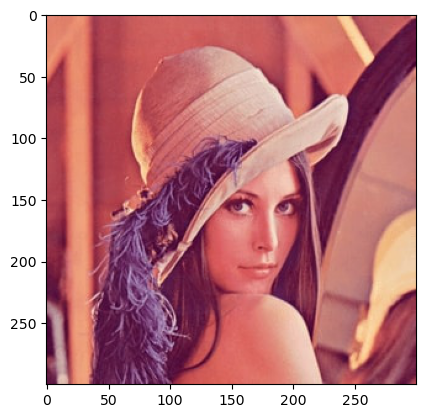

In [7]:
input_image = input_image()

In [8]:
# Belgede belirtilen matrisin oluşturulması
kernel_matrix = np.array([[1, 4, 7, 4, 1],
                          [4, 16, 26, 16, 4],
                          [7, 26, 41, 26, 7],
                          [4, 16, 26, 16, 4],
                          [1, 4, 7, 4, 1]])

kernel_matrix = kernel_matrix/273

Valid convolution işlemi sonrasında oluşacak yeni çözünürlük;
 - n = resim boyutu
 - f = kernel matris boyutu
 - s = stride olacak şekilde

 = ((n * f) / s) + 1 formülü ile hesaplanır.

In [9]:
# Boyutunu belirlemek için yukarıdaki formül kullanılır. Stride=1 olduğu için hesaplamaya dahil edilmedi.

# valid_conv_resolution değerinin hesaplanabilmesi için shape özelliğinden boyutların alınmasının sağlanması için.
input_image_np = np.array(input_image, dtype="int32")

# Valid convolution işlemi sonucunda elde edilecek resimin çözünürlüğünün belirlenmesi. Stride = 1 olduğu için hesaplamaya dahil edilmedi
valid_conv_resolution = (input_image_np.shape[0] - kernel_matrix.shape[0]) + 1

# Valid convolution sonucu oluşacak resim boyutunda sıfır değerlerinden oluşan ve işlem değerlerinin atanacağı matris.
image_zero = np.zeros((valid_conv_resolution,valid_conv_resolution,input_image_np.shape[2]), dtype="int32")

# Thread'lerin aynı bölge üzerinde işlem yapmaması için oluşturulan kontrol matrisi
convolve_control = np.array(image_zero, dtype="bool")

# İsterlerde belirtilen histogram grafiğinin elde edilmesi için, işlem değerlerinin kaydedilmesi
histogram_list = list([[],[],[]])

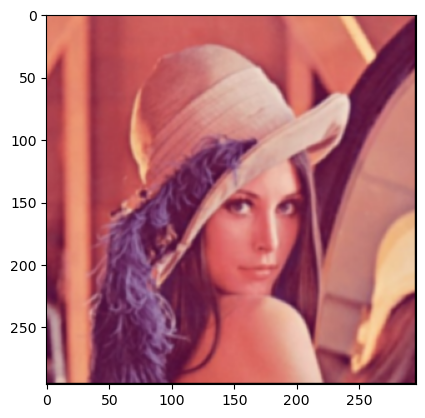

In [10]:
# İsterde belirtildiği üzere resim olarak girdi alan ve valid convolution işlemini
# Yine isterde belirtilen Thread sayısı ile yapan program fonksiyonu
custom_threading(valid_convolution, input_image, kernel_matrix)

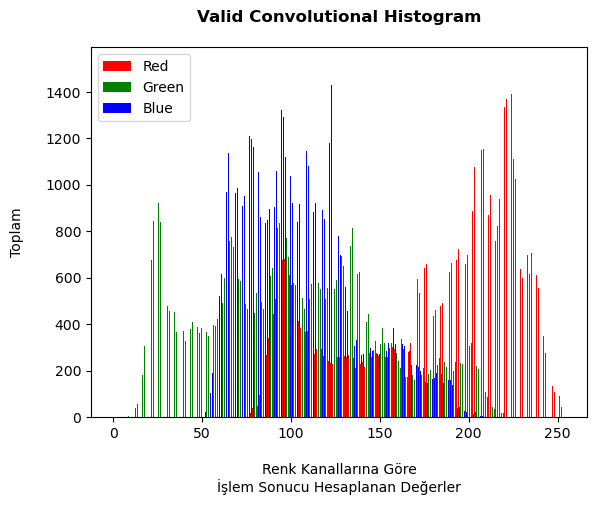

In [11]:
colors = ["Red","Green","Blue"]

# İsterlerde belirtilen hesaplanan değerler üzerinden, matrisin histogram grafiğinin renk kanallarına göre görselleştirilmesi
plt.hist(histogram_list,bins=range(0,255,1), color=colors, histtype ='bar', label=colors)
plt.legend(prop ={'size': 10})
plt.ylabel("Toplam\n")
plt.xlabel("\nRenk Kanallarına Göre\nİşlem Sonucu Hesaplanan Değerler")
plt.title('Valid Convolutional Histogram\n',fontweight ="bold")
plt.show()

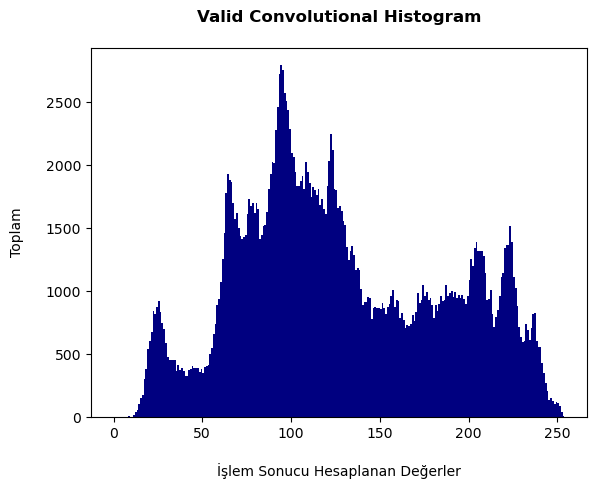

In [12]:
# Renk kanalları üzerinden tutulan değerlerin düzleştirilerek genel histogram grafiğinin oluşturulması
histogram_list_flatten = [histogram_list for sublist in histogram_list for histogram_list in sublist]

# İsterlerde belirtilen hesaplanan değerler üzerinden, matrisin histogram grafiğinin görselleştirilmesi
plt.hist(histogram_list_flatten, bins=range(0,255,1), histtype ='bar', color="navy")
plt.ylabel("Toplam\n")
plt.xlabel("\nİşlem Sonucu Hesaplanan Değerler")
plt.title('Valid Convolutional Histogram\n',fontweight ="bold")
plt.show()